<a href="https://colab.research.google.com/github/Hutzii/U-Net/blob/main/U_net_self.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!curl -OL https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -OL https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   350  100   350    0     0    561      0 --:--:-- --:--:-- --:--:--   561
100   185  100   185    0     0    164      0  0:00:01  0:00:01 --:--:--   640
100  755M  100  755M    0     0  29.4M      0  0:00:25  0:00:25 --:--:-- 31.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   355  100   355    0     0    818      0 --:--:-- --:--:-- --:--:--   817
100   185  100   185    0     0    212      0 --:--:-- --:--:-- --:--:--   212
100 18.2M  100 18.2M    0     0  8677k      0  0:00:02  0:00:02 --:--:-- 18.1M


In [ ]:
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

In [ ]:
!ls

annotations	    images	   oxford_segmentation.h5  TensorBoard
annotations.tar.gz  images.tar.gz  sample_data


In [ ]:
!file images/keeshond_13.jpg

images/keeshond_13.jpg: JPEG image data, JFIF standard 1.01, resolution (DPI), density 72x72, segment length 16, baseline, precision 8, 375x500, components 3


In [ ]:
import os

input_dir = 'images'
target_dir = 'annotations/trimaps'
img_size = (160,160)
num_classes = 3
batch_size = 32

input_img_paths = sorted([os.path.join(input_dir,fname) for fname in os.listdir(input_dir) if fname.endswith('.jpg')])

target_img_paths = sorted([os.path.join(target_dir,fname)
                          for fname in os.listdir(target_dir)
                          if fname.endswith('.png') and not fname.startswith('.')])



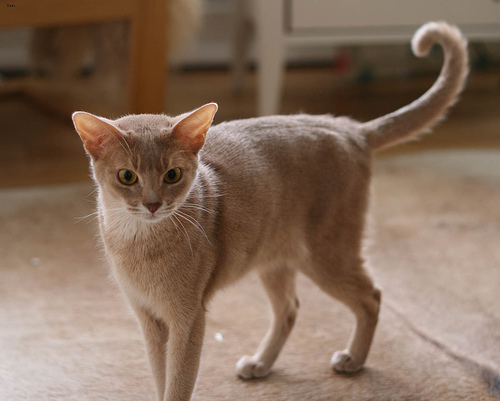

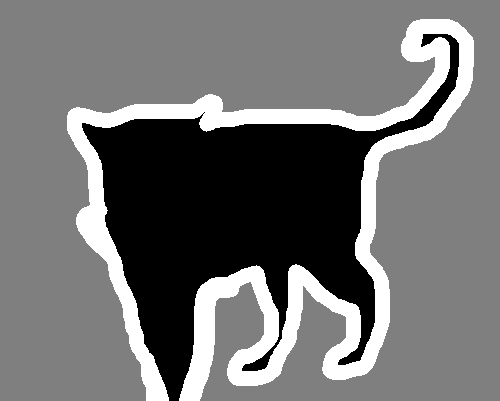

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

display(Image(filename=input_img_paths[20]))

img = PIL.ImageOps.autocontrast(load_img(target_img_paths[20]))
display(img)

In [ ]:
import numpy as np
from tensorflow import keras

class OxfordPets(keras.utils.Sequence):
  def __init__(self,batch_size,img_size,input_img_paths,target_img_paths):
    self.batch_size = batch_size
    self.img_size = img_size
    self.input_img_paths= input_img_paths
    self.target_img_paths = target_img_paths

  def __len__(self):
    return len(self.target_img_paths) // self.batch_size

  def __getitem__(self,idx):
    i = idx * self.batch_size
    batch_input_img_paths = self.input_img_paths[i:i+self.batch_size]
    batch_target_img_paths = self.target_img_paths[i:i+self.batch_size]
    x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype='float32')
    for j, path in enumerate(batch_input_img_paths):
      img = load_img(path,target_size=self.img_size)
      x[j] = img #입력
    y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype='uint8')
    for j, path in enumerate(batch_target_img_paths):
      img = load_img(path,target_size=self.img_size, color_mode='grayscale')
      y[j] = np.expand_dims(img,2) #ground_truth label은 1,2,3 으로 되어있지만 활용할때는 0,1,2동작
      y[j] -= 1 # 위와 같은 이유로 -1
    return x,y



In [ ]:
import random
val_sampels = 1000

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_sampels]
train_target_img_paths = target_img_paths[:-val_sampels]
val_input_img_paths = input_img_paths[-val_sampels:]
val_target_img_paths = target_img_paths[-val_sampels:]

train_gen = OxfordPets(batch_size,img_size,train_input_img_paths,train_target_img_paths)
val_gen = OxfordPets(batch_size,img_size,val_input_img_paths,val_target_img_paths)

In [ ]:
from tensorflow.keras import layers

def get_model(img_size,num_classes):
  inputs = keras.Input(shape=img_size + (3,))
  #U-Net 모습 구성
  #Downsample
  x = layers.Conv2D(32,3,strides=2,padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  previous_block_activation = x #이전 블록을 옆으로 넘기기 위해 사용

  for filters in [64,128,256]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters,3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters,3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2,padding='same')(x)

    residual = layers.Conv2D(filters,1,strides=2,padding='same')(previous_block_activation)
    x = layers.add([x,residual])
    previous_block_activation = x
  for filters in [256,128,64,32]:
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters,3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters,3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D(2)(x)

    residual = layers.UpSampling2D(2)(previous_block_activation)
    residual = layers.Conv2D(filters,1,padding='same')(residual)

    x = layers.add([x,residual])
    previous_block_activation = x

  outputs = layers.Conv2D(num_classes,3,activation='softmax',padding='same')(x)

  model = keras.Model(inputs,outputs)
  return model

model = get_model(img_size,num_classes)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_36 (Conv2D)             (None, 80, 80, 32)   896         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_60 (BatchN  (None, 80, 80, 32)  128         ['conv2d_36[0][0]']              
 ormalization)                                                                                    
                                                                                            

In [ ]:
model.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy')

callbacks = [keras.callbacks.ModelCheckpoint('oxford_segmentation.h5', svae_best_only=True)]

epochs = 20
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/20
199/199 [==============================] - 43s 161ms/step - loss: 0.8644 - val_loss: 2.7884
Epoch 2/20
199/199 [==============================] - 32s 159ms/step - loss: 0.5030 - val_loss: 3.6992
Epoch 3/20
199/199 [==============================] - 32s 161ms/step - loss: 0.4310 - val_loss: 0.5126
Epoch 4/20
199/199 [==============================] - 32s 162ms/step - loss: 0.3896 - val_loss: 0.4014
Epoch 5/20
199/199 [==============================] - 32s 161ms/step - loss: 0.3561 - val_loss: 0.3965
Epoch 6/20
199/199 [==============================] - 32s 161ms/step - loss: 0.3293 - val_loss: 0.3768
Epoch 7/20
199/199 [==============================] - 32s 161ms/step - loss: 0.3057 - val_loss: 0.4715
Epoch 8/20
199/199 [==============================] - 32s 161ms/step - loss: 0.2847 - val_loss: 0.4057
Epoch 9/20
199/199 [==============================] - 32s 161ms/step - loss: 0.2623 - val_loss: 0.4689
Epoch 10/20
199/199 [==============================] - 32s 161ms/step - l

31/31 [==============================] - 3s 105ms/step


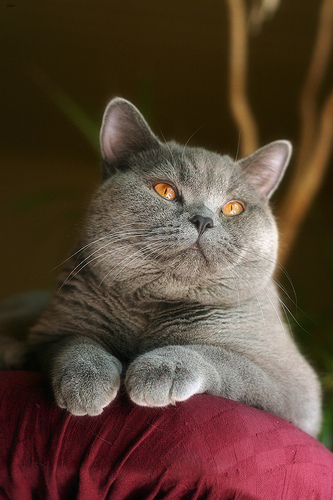

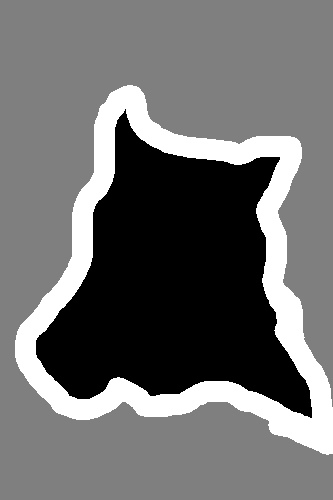

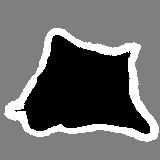

In [ ]:
val_preds = model.predict(val_gen)

def display_mask(i):
  mask = np.argmax(val_preds[i], axis = -1)
  mask = np.expand_dims(mask,axis=-1)
  img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
  display(img)

i = 10

display(Image(filename=val_input_img_paths[i]))
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)
display_mask(i)

